# Spatial graph comparisons using graphcompass  
### Spatial pancreas
Sander - Theis collab 

**Conditions:**
- ND: non-diabetic
- T1D: type 1 diabetic

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import squidpy as sq
import graphcompass as gc

### Load data

In [2]:
folder = '/lustre/groups/ml01/datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/'
file   = 'S1_annotated_l0.h5ad' #'imputed_envi.h5ad'
adata = sc.read(filename = folder + file)
adata

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [ ]:
adata.obs.head()

In [2]:
# define library_key and cluster_key for computing spatial graphs using `squidpy.gr.spatial_neighbors` and 
# `squidpy.gr.nhood_enrichment` 
# spatial graphs are used by the different methods in GraphCompass

library_key="fov"
cluster_key="cell_type_coarse"

# define condition_key used in comparisons
condition_key="condition" # key in adata.obs where conditions are stored

In [ ]:
import pandas as pd
x = pd.crosstab(adata.obs.fov, adata.obs.condition)
x

In [ ]:
adata.X = adata.X.toarray()

### 1. Entire graph comparison

GraphCompass provides two methods to perform holistic graph comparisons:

A. Weisfeiler-Lehman graph kernels, and  
B. filtration curves.

Both methods result in graph embeddings that can be compared against one another to obtain a broad measure of tissue architecture similarity.

#### A. Weisfeiler-Lehman graph kernels

Compute Weisfeiler-Lehman Graph Kernels to compare conditions

# compute WWL kernels
### results are stored in adata.uns["wl_kernel"]

gc.tl.wlkernel.compare_conditions(
   adata=adata,
   library_key=library_key,
   cluster_key=cluster_key,
   compute_spatial_graphs=True,
   kwargs_spatial_neighbors={
        'coord_type': 'generic',
        'delaunay': True,  
  }  
)

In [4]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
file   = 'S3_annotated_l0_wlkernel.h5ad' #'imputed_envi.h5ad'
adata_wlkernel = sc.read(filename = folder + file)
adata_wlkernel

AnnData object with n_obs × n_vars = 151595 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_coarse_fov_nhood_enrichment', 'log1p', 'spatial', 'spatial_neighbors', 'wl_kernel'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [5]:
# define necessary params
control_group="ND" # reference group
metric_key="wasserstein_distance" 
method="wl_kernel"

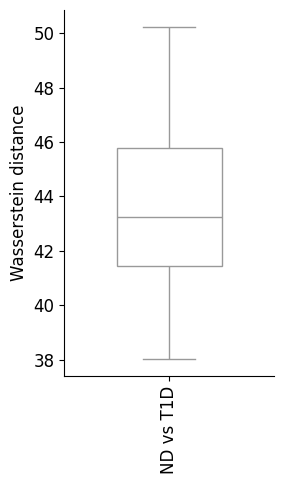

In [6]:
# Note: a smaller Wasserstein distance indicates a higher similarity between the two graphs, 
# while a larger distance indicates less similarity.

gc.pl.wlkernel.compare_conditions(
    adata=adata_wlkernel,
    library_key=library_key,
    condition_key=condition_key,
    control_group=control_group,
    metric_key=metric_key,
    method=method,
    figsize=(3,5),
    dpi=100,
    #save="figures/mibitof_wwlkerenl.pdf"
)

#### Filtration curves

Compute filtration curves to compare conditions

In [7]:
# compute filtration curves
### results are stored in adata.uns["filtration_curves"]

# Note: in our case, the spatial graphs have been computed previously (to obtain the WL kernels), so we can set
## `compute_spatial_graphs` to False to save compute time. Otherwise, it should be set to True and 
## `kwargs_spatial_neighbors` should be set depending on the technology used to obtain the spatial data.

gc.tl.filtration_curves.compare_conditions(
    adata=adata_wlkernel,
    library_key=library_key,
    cluster_key=cluster_key,
    condition_key=condition_key,
    compute_spatial_graphs=False,
#     kwargs_spatial_neighbors={
#         'coord_type': 'generic',
#         'delaunay': True,  
#     }  
    
)

Computing spatial graph...
Computing edge weights...


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Computing edge weight threshold values...
Creating filtration curves...


100%|██████████| 25/25 [00:00<00:00, 61.27it/s]

Done!


In [9]:
# define necessary params
node_labels=["Acinar","Alpha", "Beta"] # node labels (e.g. cell types) we are intrested in visualising
metric_key="filtration_curves"

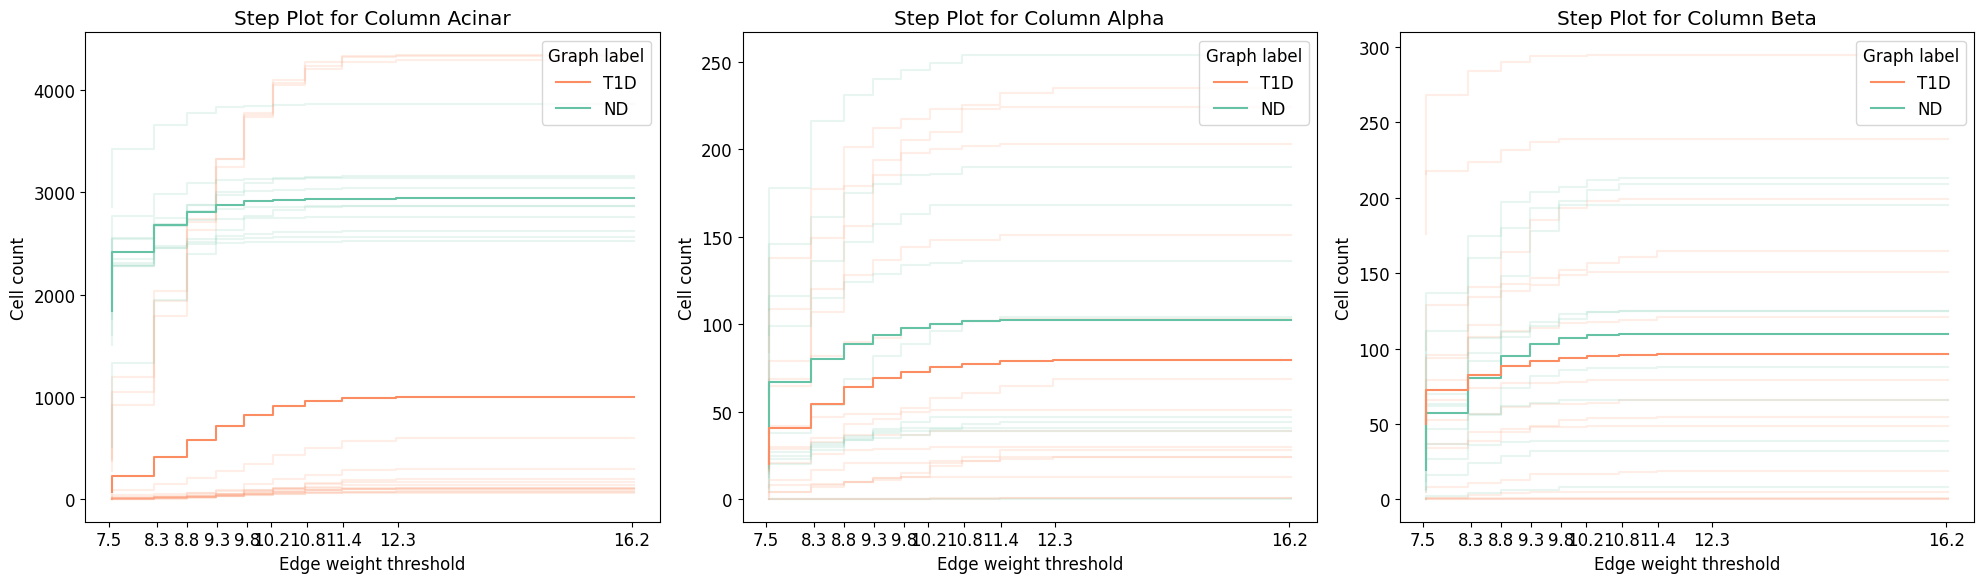

In [10]:
gc.pl.filtration_curves.compare_conditions(
    adata=adata_wlkernel,
    node_labels=node_labels,
    metric_key=metric_key,
    palette="Set2",
    dpi=100,
    figsize=(20,6),
    #save="figures/mibitof_filtration_curves.pdf"
)

### Specific-cell-type subgraphs comparison

In [13]:
# compute pairwise similarities between cell-type-specific graphs across samples
### results are stored in adata.uns["pairwise_similarities"]

# Note: in our case, the spatial graphs have been computed previously (to obtain the WL kernels), so we can set
## `compute_spatial_graphs` to False to save compute time. Otherwise, it should be set to True and 
## `kwargs_spatial_neighbors` should be set depending on the technology used to obtain the spatial data.

gc.tl.distance.compare_conditions(
    adata=adata_wlkernel,
    library_key=library_key,
    cluster_key=cluster_key,
    method="portrait",
    compute_spatial_graphs=False,
#     kwargs_spatial_neighbors={
#         'coord_type': 'generic',
#         'delaunay': True,  
#     }  
)

Spatial graphs were previously computed. Skipping computing spatial graphs 
Computing graph similarities...


100%|██████████| 9/9 [1:06:29<00:00, 443.29s/it] 

Done!


In [14]:
adata_wlkernel

AnnData object with n_obs × n_vars = 151595 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_coarse_fov_nhood_enrichment', 'log1p', 'spatial', 'spatial_neighbors', 'wl_kernel', 'filtration_curves', 'pairwise_similarities'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 

In [15]:
# define necessary params
control_group="ND" # reference group

9it [00:02,  3.14it/s]


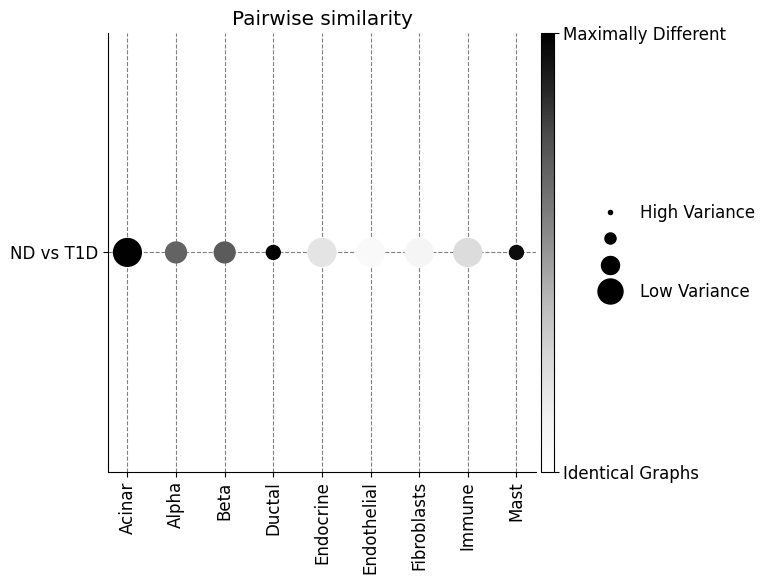

In [16]:
# Note: The size of the dot is indicative of the similarity score variance over samples. 
# The larger the dot size, the lower the score variance and the higher the score confidence is.

gc.pl.distance.compare_conditions(
    adata=adata_wlkernel,
    library_key=library_key,
    condition_key=condition_key,
    control_group=control_group,
    # add_ncells_and_density_plots=True,
    palette="Greys",
    dpi=100,
    figsize=(8,6),
#     save="figures/mibitof_portrait.pdf"
)

In [17]:
adata_wlkernel

AnnData object with n_obs × n_vars = 151595 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_coarse_fov_nhood_enrichment', 'log1p', 'spatial', 'spatial_neighbors', 'wl_kernel', 'filtration_curves', 'pairwise_similarities'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 

In [19]:
sq.tl.var_by_distance(
    adata=adata_wlkernel,
    groups="Beta",
    cluster_key="cell_type_coarse",
    library_key="fov",
    covariates=["condition"],
)

In [21]:
adata_wlkernel.obsm["design_matrix"]

,cell_type_coarse,fov,Beta,Beta_raw,condition
1_1,Ductal,1,0.306690,1612.586122,T1D
2_1,Ductal,1,0.327018,1719.472303,T1D
3_1,Ductal,1,0.339435,1784.760488,T1D
4_1,Ductal,1,0.380668,2001.564388,T1D
5_1,Ductal,1,0.336577,1769.730205,T1D
...,...,...,...,...,...
7236_25,Ductal,25,0.147821,777.248995,T1D
7237_25,Acinar,25,0.685781,3605.860369,T1D
7239_25,Ductal,25,0.734220,3860.552940,T1D
7240_25,Mast,25,0.724373,3808.773687,T1D


In [24]:
adata_wlkernel.X = adata_wlkernel.X.toarray()

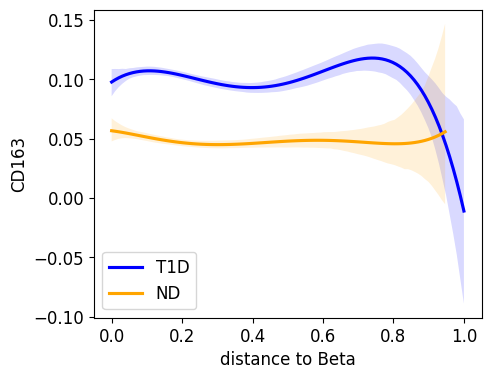

In [26]:
sq.pl.var_by_distance(
    adata=adata_wlkernel,
    design_matrix_key="design_matrix",
    var="CD163",
    anchor_key="Beta",
    covariate="condition",
    line_palette=["blue", "orange"],
    show_scatter=False,
    figsize=(5, 4),
)

In [27]:
adata_wlkernel

AnnData object with n_obs × n_vars = 151595 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_coarse_fov_nhood_enrichment', 'log1p', 'spatial', 'spatial_neighbors', 'wl_kernel', 'filtration_curves', 'pairwise_similarities', 'design_matrix'
    obsm: 'spatial', 'spatial_fov', 'design_matri